# "Predict the Cooperative Patent Class (CPC) by means of NLP"
> "The application of data science techniques in the realm of patent analysis is in rapid growth, due to the availability of large quantity of data.
Such a science leverages data to create better business intelligence, as
well as facilitates decision making processes. However, there are specific business cases which have not been addressed yet. Firstly, this
paper challenges the status quo and recommends a machine learningdriven classification of patent publications based on a predictive model
trained on the text data. The paper finds that a LinearSVC achieves
best results, scoring an accuracy value of 66%. Secondly, the paper
builds an inventor-level network related to a Danish Pharmaceutical
company, and it identifies the most influential inventors among the
largest communities detected by means of a UML application. The
paper argues that network analysis would be instrumental in solving
cases where companies have lost tracks of inventors."

- toc: true
- branch: master
- badges: true
- hide_{binder,deepnote}_badge: true
- comments: true
- categories: [NLP, Network Analysis, Intellectual property, Patent data]
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Imports

In [ ]:
import pandas as pd # data analysis
from io import StringIO 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_selection import chi2

## Load the data 
The data source of the patent-level data is PatBase, that is a product offered by MineSoft, i.e., patent solutions provider founded in 1996 offering online products and services, such as, patent research, monitoring, and analysis, as well as other intellectual property services.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSBA Patent Project /EDA & NLP /patbase_export_274777127.csv')
## df.head()

## Subset the data 
The only two features needed in this prediction exercise are the Cooperative Patent Class and the text of the 1' Main Claim.  

In [ ]:
col = ['Cooperative Patent Class', '1st Main Claim'] #we only use those two columns 
df = df[col]

In [ ]:
df = df.dropna()

## Text manipulation 
We can see that each patent publication, i.e., each row, has multiple CPC labels. For convinience, we only use the first label in order of appearance. 

In [ ]:
df['cpc'] = df['Cooperative Patent Class'].str.extract(r'(^.{0,1})')

## Preprocessing of the man claim text 

In [ ]:
df['main_claim'] = df['1st Main Claim'].str.replace('\[EN\]\s1.\s', '', regex = True) # string stripping EN

## EDA of the CPC 
We found that there are 8 unique classes among the all data set.

In [ ]:
df['cpc'].nunique()

8

## Subsetting the data to allow Colab to process the command

In [ ]:
df = df.sample(frac = 0.2)

In [ ]:
df['category_id'] = df['cpc'].factorize()[0] # we add a column encodnig the cpc as 
# an integer because categorical variables are better represented by integers than strings.  
# cosa corrisponde a cosa???? 

In [ ]:
category_id_df = df[['cpc', 'category_id']].drop_duplicates().sort_values('category_id')

In [ ]:
category_id_df 

,cpc,category_id
3368,G,0
713,H,1
4842,A,2
18950,C,3
18037,B,4
23669,F,5
21886,E,6
10205,D,7


In [ ]:
category_to_id = dict(category_id_df.values) # a dictionary of category to id integer

In [ ]:
category_to_id

{'A': 2, 'B': 4, 'C': 3, 'D': 7, 'E': 6, 'F': 5, 'G': 0, 'H': 1}

In [ ]:
id_to_category = dict(category_id_df[['category_id', 'cpc']].values) # a dictionary of id integer to category

In [ ]:
id_to_category

{0: 'G', 1: 'H', 2: 'A', 3: 'C', 4: 'B', 5: 'F', 6: 'E', 7: 'D'}

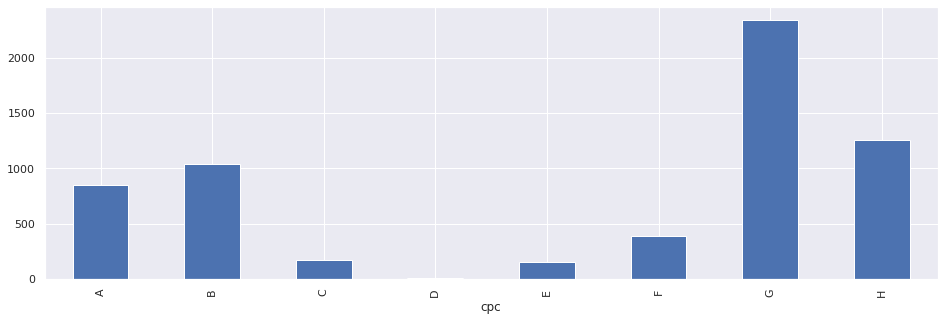

In [ ]:
fig = plt.figure(figsize=(16,5))
df.groupby('cpc').main_claim.count().plot.bar(ylim = 0)
plt.show()

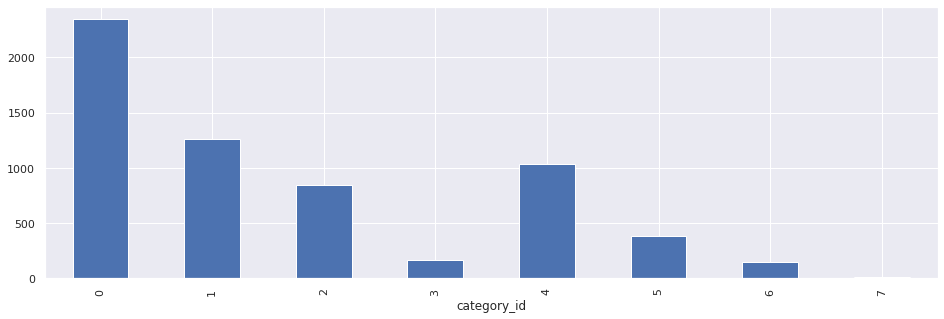

In [ ]:
fig = plt.figure(figsize=(16,5))
df.groupby('category_id').main_claim.count().plot.bar(ylim = 0)
plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(sublinear_tf=True, # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf). 
                        min_df=5,# minimum numbers of documents a word must be present in to be kept. 
                        norm='l2', # I am not sure about this parameter
                        encoding='latin-1', # I am not sure about this parameter  
                        ngram_range=(1, 2), # consider both unigrams and bigrams.
                        stop_words='english') # remove all common pronouns
features = tfidf.fit_transform(df.main_claim).toarray
labels = df['cpc']
features.shape

(6203, 14642)

In [ ]:
features_names = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
features1 = tfidf.fit_transform(df.main_claim)

In [ ]:
dense = features1.todense()

In [ ]:
denselist = dense.tolist()

In [ ]:
df_features = pd.DataFrame(denselist, columns= features_names)

In [ ]:
df_features.head(3)

,00,000,001,01,01 percent,02,05,10,10 degrees,10 min,10 nm,10 percent,100,100 parts,100 percent,1000,11,110,111,12,120,125,13,14,140,15,15 percent,150,16,17,18,180,180 degrees,19,20,20 degrees,20 percent,20 wt,200,21,...,working fluid,workload,workpiece,world,worn,wound,woven,wrap,wrapped,wrapping,wraps,wrist,write,write command,write data,write operation,write request,writes,writing,writing data,written,written second,wt,wt percent,x1,x2,x3,yield,yl,yoke,zero,zinc,zirconium,zn,zn combinations,zone,zone based,zones,zoom,zooming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prediction of CPC label using Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['main_claim'], 
                                                    df['cpc'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
MultinomialNB = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(MultinomialNB.predict(count_vect.transform(["A user device comprising: one or more processors; anda computer-readable medium storing a plurality of computer-executable components that are executable by the one or more processors to perform a plurality of actions, the plurality of actions comprising:receiving supplemental scheduling information, the supplemental scheduling information being generated based on telemetry data collected from a plurality of access points of a data network;requesting an access point of the data network for accessing a wireless local area network according to a wireless usage type, the wireless usage type based on an application running on the user device and the supplemental scheduling information; andreceiving an allocation of time-frequency divisions for accessing the wireless local area network from the access point."])))

['G']


## Selection of various model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies): entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.660002
LogisticRegression        0.645332
MultinomialNB             0.584395
RandomForestClassifier    0.381590
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 66%. Focusing on the LinearSVC model, which has demonstrated to perform the best, I report its confusing matrix, to show the discrepancies between predicted and actual labels.

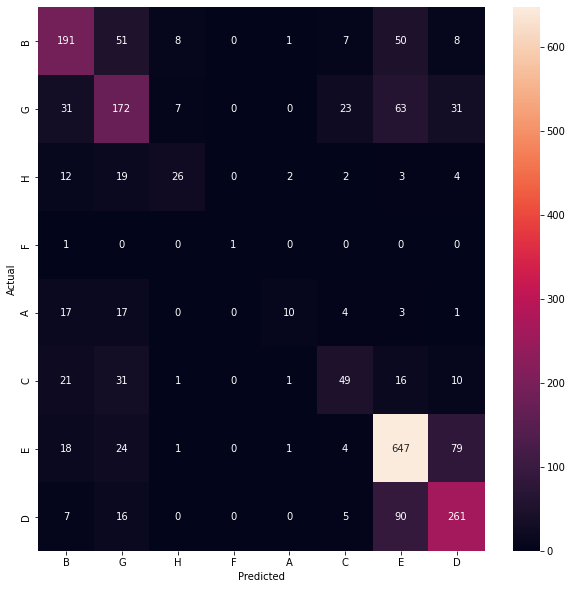

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.cpc.values, yticklabels=category_id_df.cpc.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()